In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from util.data import *
from util import preprocess
from models.enc_dec import train_encoder, LSTMEncoderDecoder
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm

import sys
from IPython.utils import io

sns.set()
palette = sns.color_palette("Reds", n_colors=40)
sns.set_palette(reversed(palette), n_colors=40)
plt.rcParams['figure.figsize'] = (12, 5)
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 15

## Concatenate selected stable countries into a single dataframe
This is simply to make preprocessing a little simpler. We'll drop a few columns, and one-hot encode a few more before splitting the dataframe back into individual countries. 

In [2]:
# Europe, Asia, North America
countries = ['United Kingdom', 'France', 'Costa Rica', 'Japan','Singapore',
             'Sweden', 'New Zealand', 'Slovenia', 'Poland', 'Finland',
             'Iceland', 'Netherlands', 'Czech Republic', 'United States',
             'Denmark', 'Portugal', 'Canada', 'Greece', 'Greenland',
             'Brazil', 'Norway', 'Switzerland', 'Australia', 'Luxembourg',
             'Austria', 'Belgium', 'Spain', 'Germany', 'China', 'Ukraine',
             'Russian Federation']


# # Middle East and Northen Africa
# countries = ['Algeria', 'Bahrain', 'Djibouti', 'Egypt', 'Iran', 'Iraq', 'Israel', 'Jordan', 
#             'Kuwait', 'Lebanon', 'Libya', 'Malta', 'Morocco', 'Oman', 'Qatar', 'Saudi Arabia',
#             'Syria', 'Tunisia', 'United Arab Emirates', 'Palestine', 'Yemen']

icews_df = pd.DataFrame()

for c in countries:
    with io.capture_output() as captured:
        df = get_country_df(c, 'data/icews/')
    icews_df = icews_df.append(df)
    
# get a time series of event rates by type:
global_ts = preprocess.run(icews_df)

## Drop fields we don't wish to analyze

In [3]:
drop = ['Event ID', 'ï»¿Event ID', 'Story ID', 'Sentence Number', 'Publisher',
        'City', 'District', 'Province']
icews_df = icews_df.drop(drop, axis=1)
icews_df = icews_df.sort_values(by=['Country', 'Event Date'])

In [4]:
icews_df.head(2)

,Event Date,Source Name,Source Sectors,Source Country,Event Text,CAMEO Code,Intensity,Target Name,Target Sectors,Target Country,Country,Latitude,Longitude,QuadClass
28039,2014-01-01,Police (Australia),"Police,Government",Australia,"Arrest, detain, or charge with legal action",17,-5.0,Men (Australia),"Social,General Population / Civilian / Social",Australia,Australia,-28.0027,153.430,4
28040,2014-01-01,Police (Australia),"Police,Government",Australia,"Arrest, detain, or charge with legal action",17,-5.0,Children (Australia),"Social,General Population / Civilian / Social",Australia,Australia,-33.9500,151.233,4


## One-hot encode Quad Class and CAMEO Codes

In [5]:
qc_dummies = pd.get_dummies(icews_df['QuadClass'], prefix='QuadClass')
cc_dummies = pd.get_dummies(icews_df['CAMEO Code'], prefix='CAMEO')
icews_df = pd.concat([icews_df, qc_dummies, cc_dummies], axis=1)
icews_df = icews_df.drop(['QuadClass', 'CAMEO Code'], axis=1)

In [6]:
icews_df.head(1)

,Event Date,Source Name,Source Sectors,Source Country,Event Text,Intensity,Target Name,Target Sectors,Target Country,Country,...,CAMEO_11,CAMEO_12,CAMEO_13,CAMEO_14,CAMEO_15,CAMEO_16,CAMEO_17,CAMEO_18,CAMEO_19,CAMEO_20
28039,2014-01-01,Police (Australia),"Police,Government",Australia,"Arrest, detain, or charge with legal action",-5.0,Men (Australia),"Social,General Population / Civilian / Social",Australia,Australia,...,0,0,0,0,0,0,1,0,0,0


## Split dataframe by country

In [7]:
# Create dictionary of country specific dataframes:
country_dict = {}
for c in icews_df.Country.unique():    
    country_dict[c] = icews_df[icews_df.Country == c]
    

## Drop countries with too many unreported days

In [8]:
missing = []

## Drop all countries missing more than 25% of reported days:
for c, df in tuple(country_dict.items()):
    
    # group by date. 
    ts = df.groupby(by='Event Date').mean()
    
    # expand index to include missing days.
    ts = ts.asfreq('d')
    
    # find all unreported days. 
    null = ts[ts.isna().all(axis=1)]
    
    # calculate percent unreported
    percent_missing = len(null) / len(ts)
    missing.append([c, percent_missing])
    
    # remove countries missing more 14% (roughly 1/7 days.)
    if percent_missing > 0.14:
        print(f'removing {c}')
        country_dict.pop(c)

missing_df = pd.DataFrame(missing, columns=['Country', '% Missing'])
missing_df = missing_df.sort_values(by='% Missing', ascending=False)

removing Austria
removing Costa Rica
removing Denmark
removing Finland
removing Greenland
removing Iceland
removing Luxembourg
removing Netherlands
removing New Zealand
removing Norway
removing Portugal
removing Slovenia
removing Sweden
removing Switzerland


## Visualize what was dropped

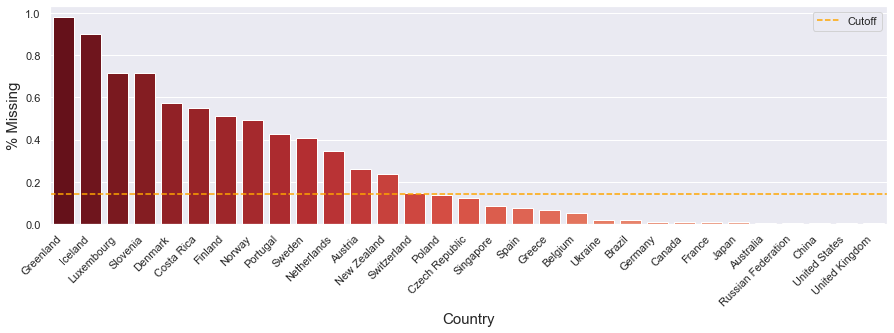

In [9]:
plt.figure(figsize=(15,4))
ax = sns.barplot(x=missing_df['Country'], y=missing_df['% Missing'], data=missing_df)
ax.axhline(y=0.14, color='orange', linestyle='--', label='Cutoff')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()

## Density of daily reports.
For the countries that remain, let's take a look at the average number of events reported per day. Higher numbers of reported events would lead to higher confidence in the aggregated scores. Lower numbers of reported events will mean that the aggregated time series 

In [10]:
missing_df['Avg Daily Reports'] = pd.Series(dtype='float64')
missing_df.set_index('Country', inplace=True)

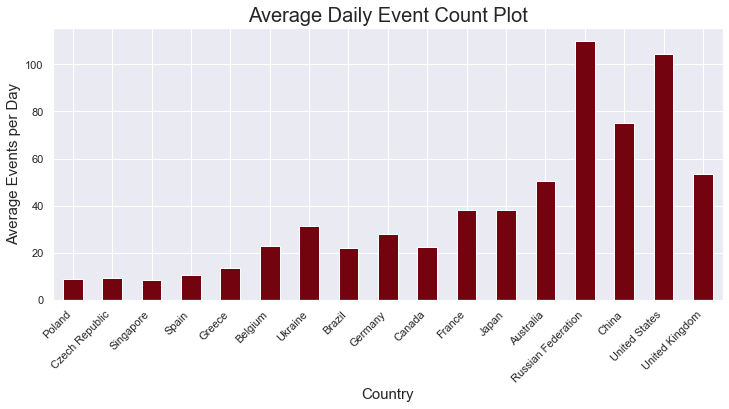

In [11]:
classes = ['QuadClass_1', 'QuadClass_2', 'QuadClass_3', 'QuadClass_4']

for c, df in tuple(country_dict.items()):
    
    avg_reports = df.groupby(["Event Date"]).sum()[classes].sum(axis=1).mean()
    missing_df.loc[c, 'Avg Daily Reports'] = avg_reports
    
missing_df['Avg Daily Reports'].dropna(axis=0).plot(kind='bar')
plt.title('Average Daily Event Count Plot')
plt.ylabel('Average Events per Day')
plt.xticks(rotation=45, ha='right');

Of the remaining countries, we see that quite a few are not well reported relative to others. 

## Look at global data as a timeseries of event rates.

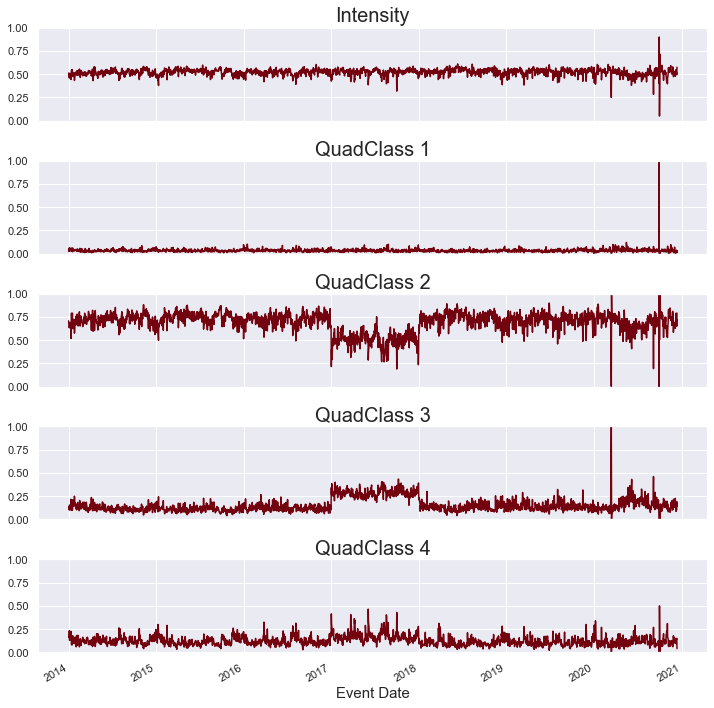

In [12]:
# Plot each timeseries in the data:
fig, axes = plt.subplots(5,1, figsize=(10, 10), sharex=True)

for col, ax in zip(global_ts, axes):
    title = f"QuadClass {col}" if len(col) == 1 else col
    global_ts[col].plot(ax=ax, title=title)
    ax.set_ylim(0, 1)

plt.tight_layout();

It looks like QC2 event rate has an inverse correlation with QC3 and QC4 event rates. Let's look closer.

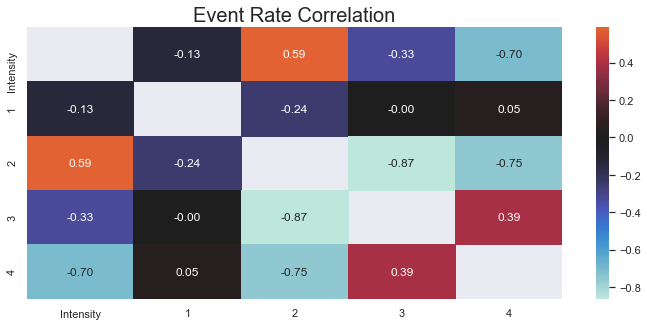

In [13]:
corr = global_ts.corr()
np.fill_diagonal(corr.values, None)

sns.heatmap(corr, annot=True, fmt='.2f', center=0)
plt.title('Event Rate Correlation');

#### Observations:
- Quad Class 1 is mostly uncorrelated to everything else. The exception is a low-moderate inverse correlation with Quad Class 2. This indicates that as material cooperation increases, verbal cooperation tends to decrease. Perhaps actors who tend to do good also tend to talk the least about it? 

- Quad Class 2 is indeed highly inversely correlated with QC3 and 4. This is mostly unsurprising. As friendly talk goes up, unfriendly talk (and action) goes down.

- Quad Class 3 and 4 are moderately correlated to one another. It might be interesting to see if there is a lead-lag trend here. 

## Aggregate ICEWS data and find correlations.
For each country, for each day, for each conflict category, find the number of events that occured. 

Then, for each country, calculate the correlation between event types. This should indicate what events tend to occur together on the same day in a given country.

Finally, average these correlation matrices to determine any global trends. 

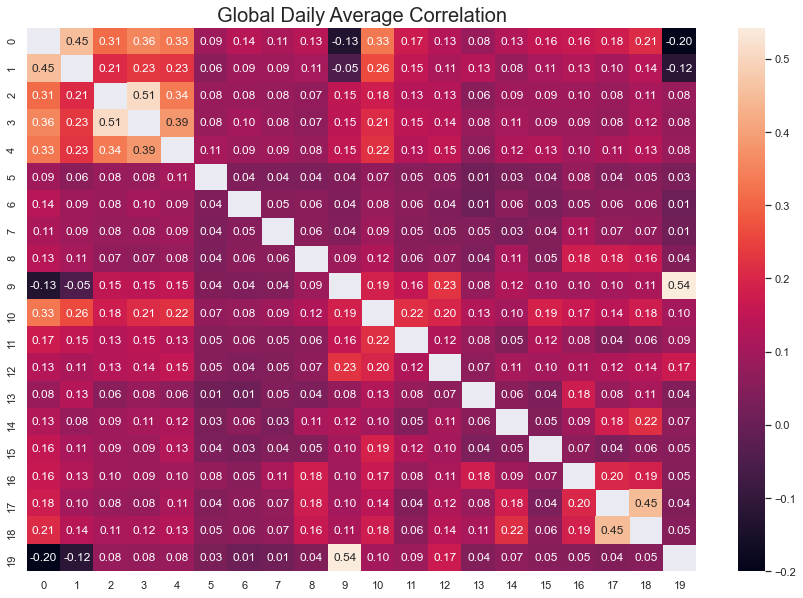

In [14]:
# quick list of important column names
cc = [f'CAMEO_{i}' for i in range(1, 21)]

corr_data = []

# get each country's daily event type correlation 
for c, df in country_dict.items():
    daily_cc_counts = df.groupby('Event Date').sum()[cc]
    corr = daily_cc_counts.corr().to_numpy()
    np.fill_diagonal(corr, None)
    corr_data.append(corr)

# Convert to Numpy array for averaging
corr_data = np.array(corr_data)

# Visualize global daily average correlation between event types
plt.figure(figsize=(15,10))
sns.heatmap(corr_data.mean(axis=0), annot=True, fmt='0.2f')
plt.title('Global Daily Average Correlation')
plt.show()

## Show individual country daily event type correlation

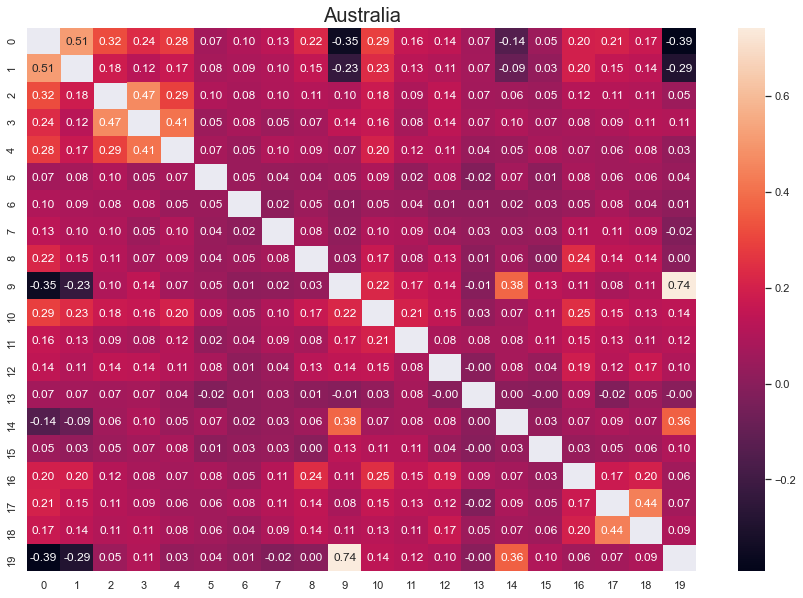

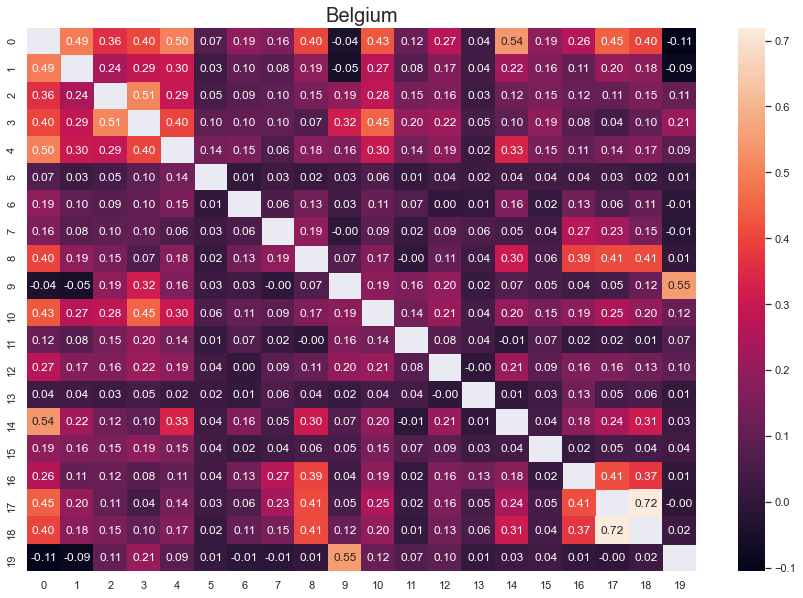

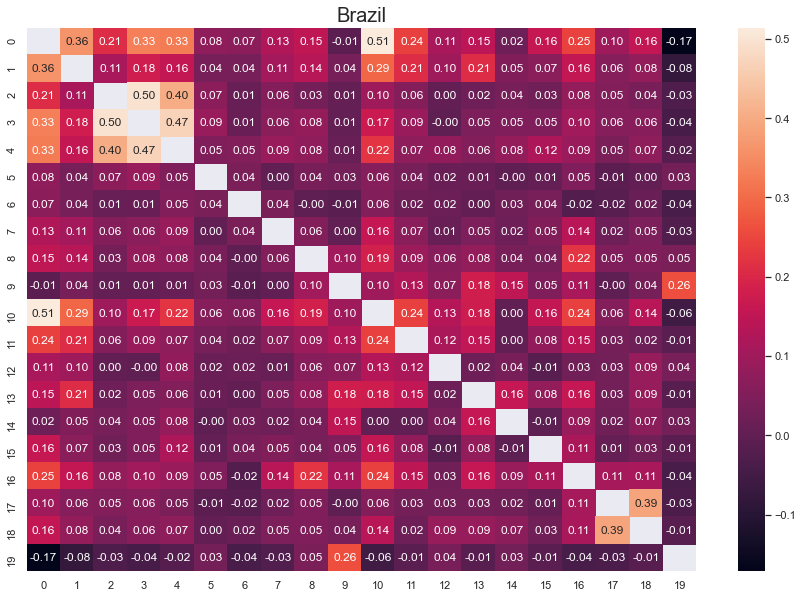

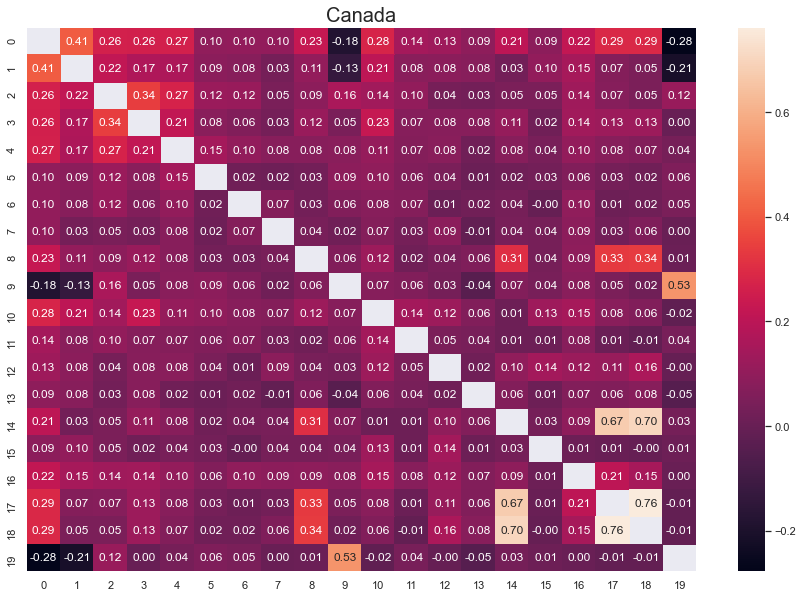

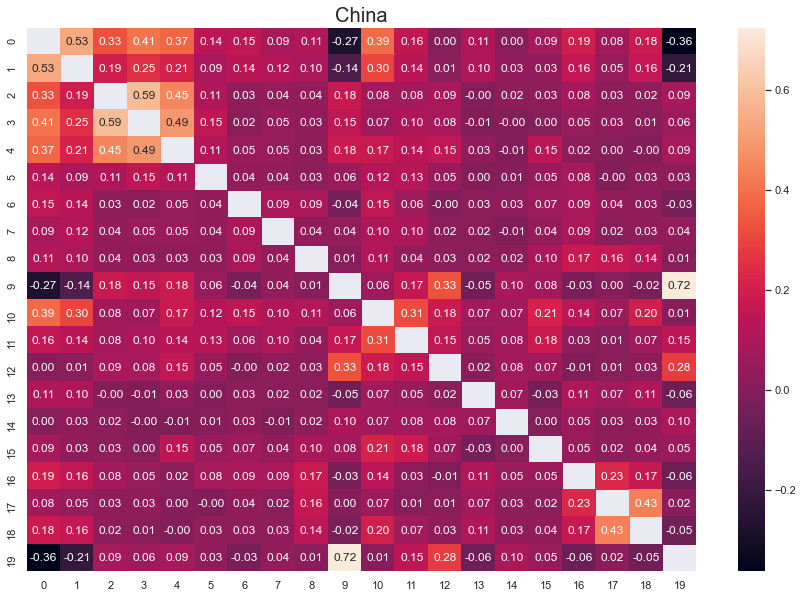

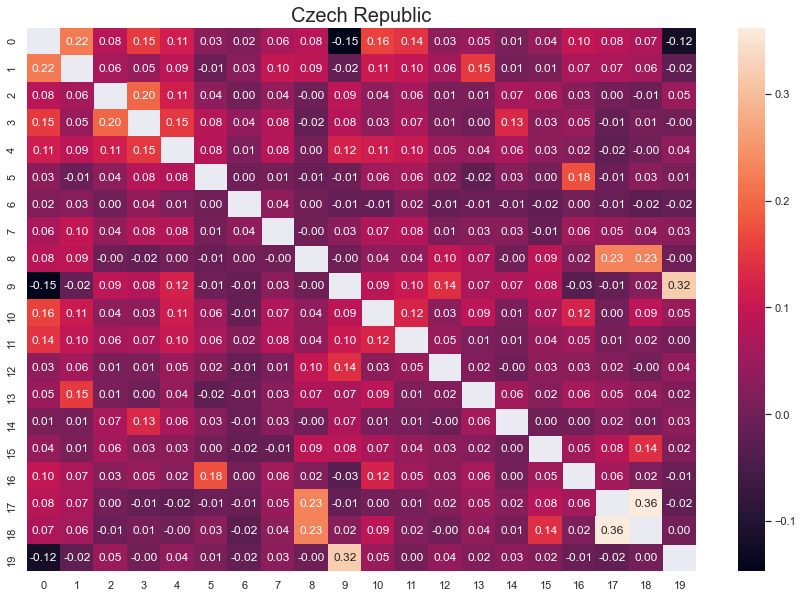

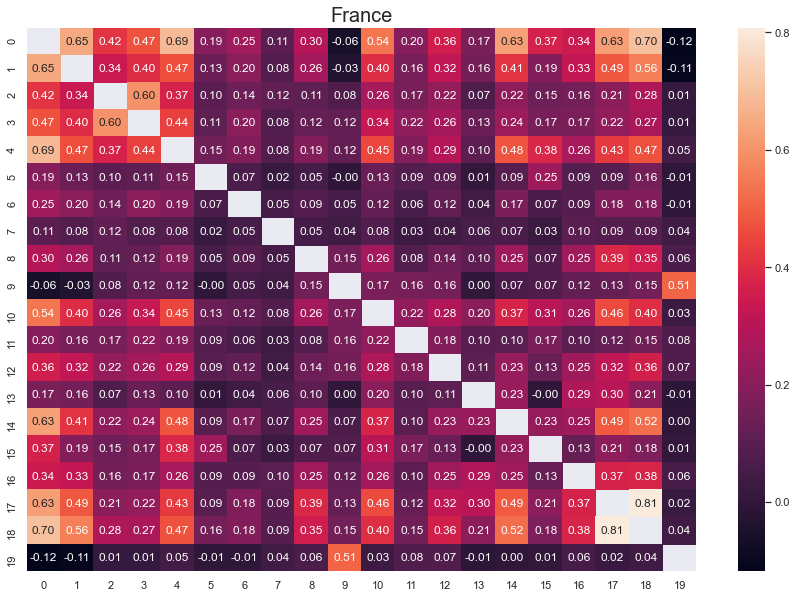

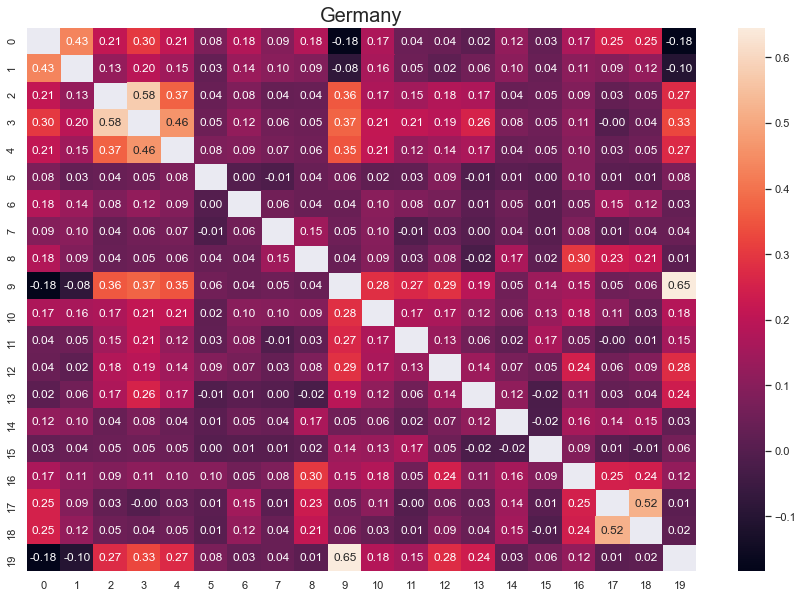

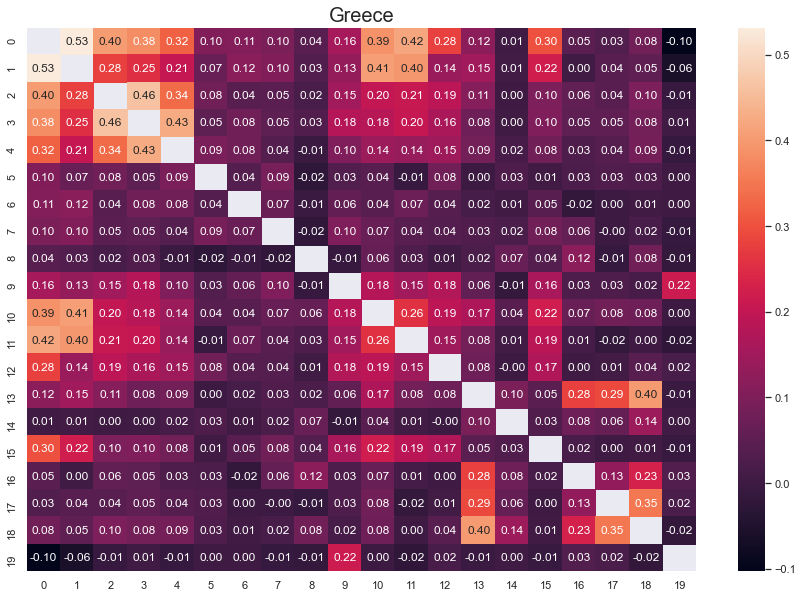

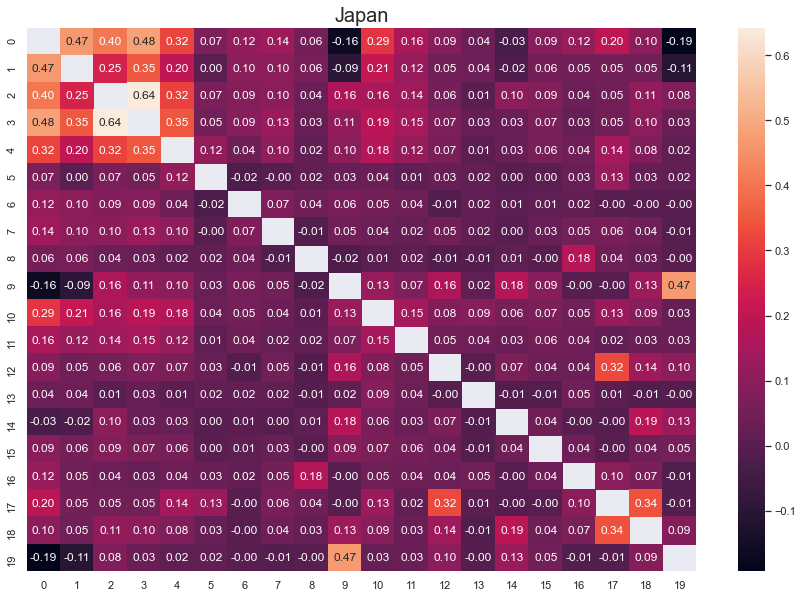

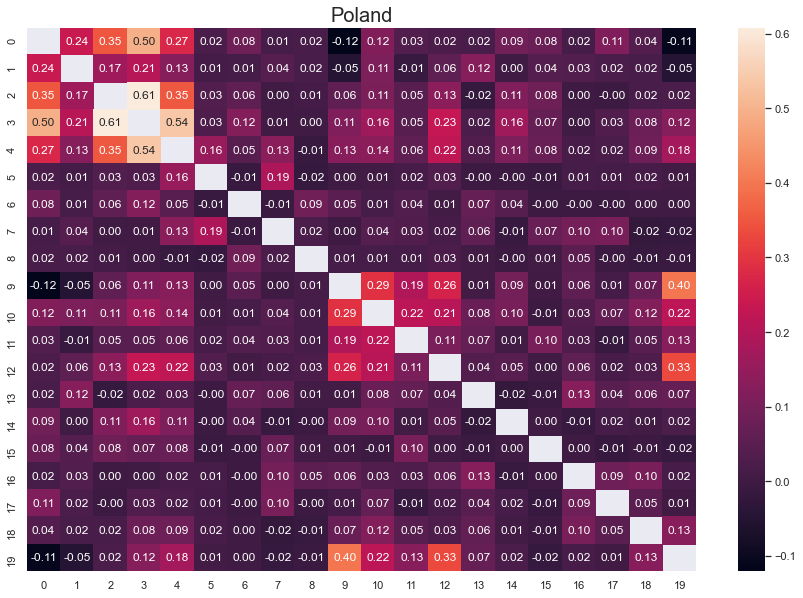

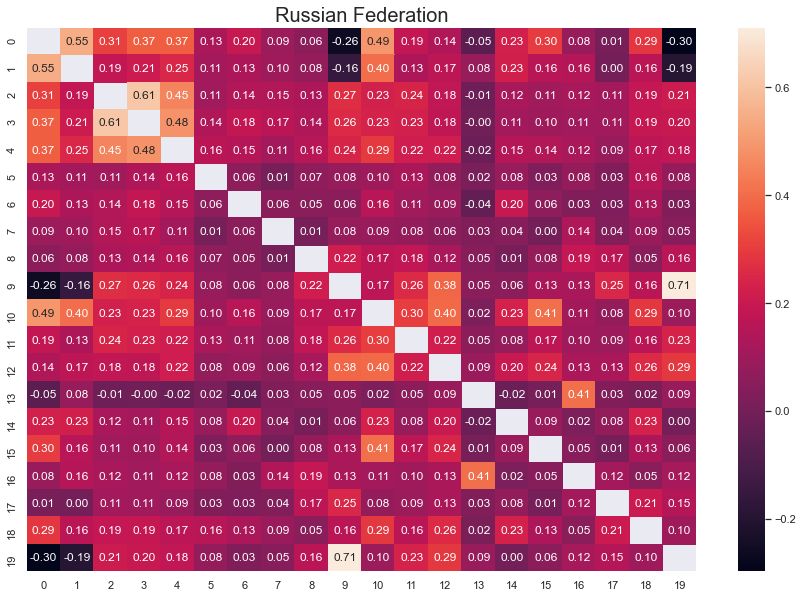

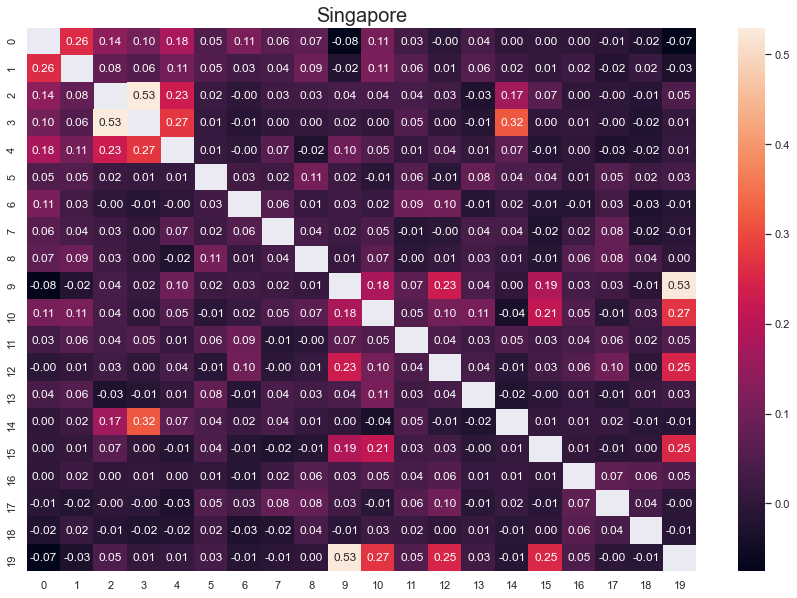

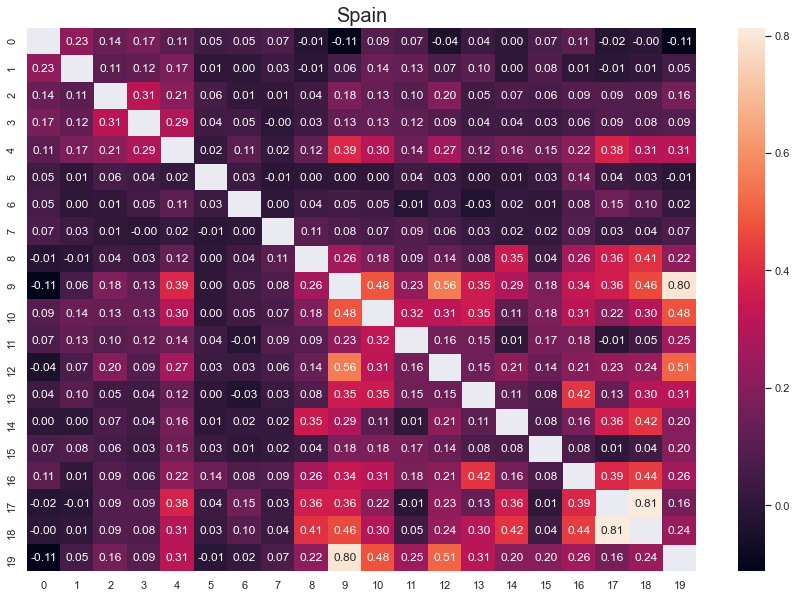

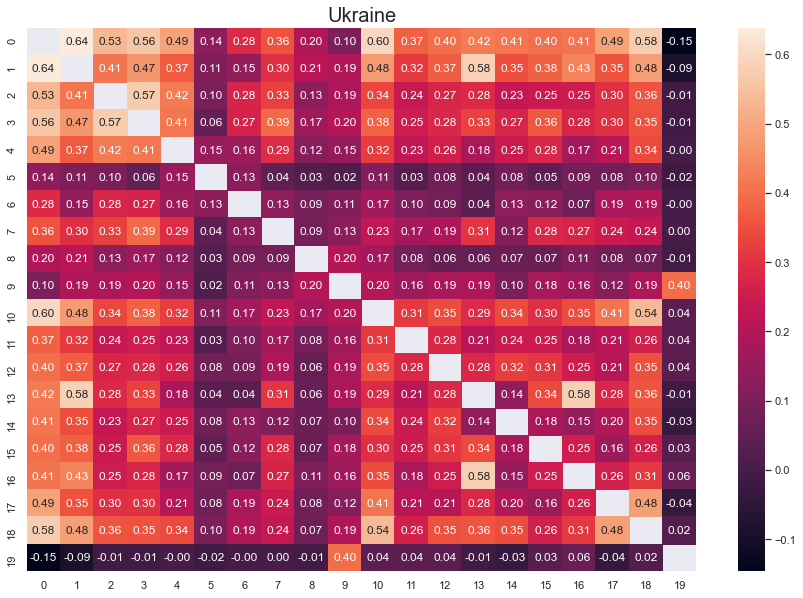

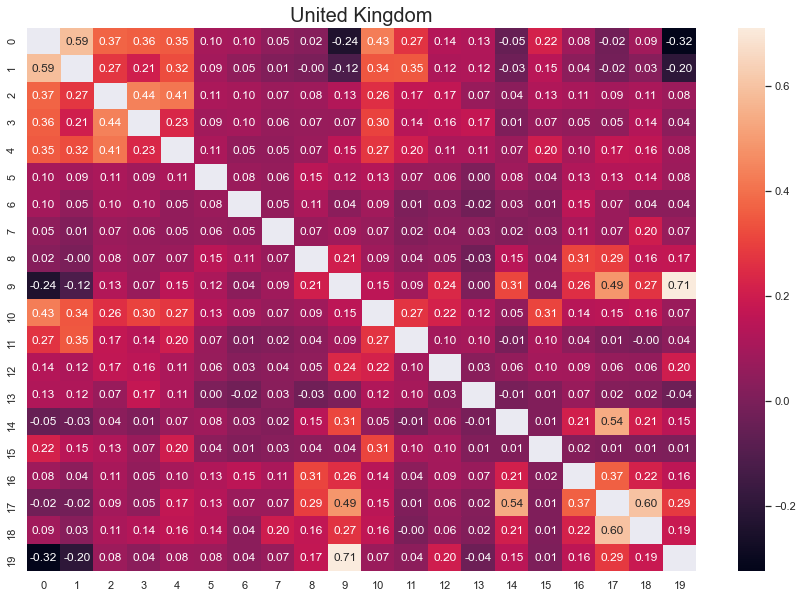

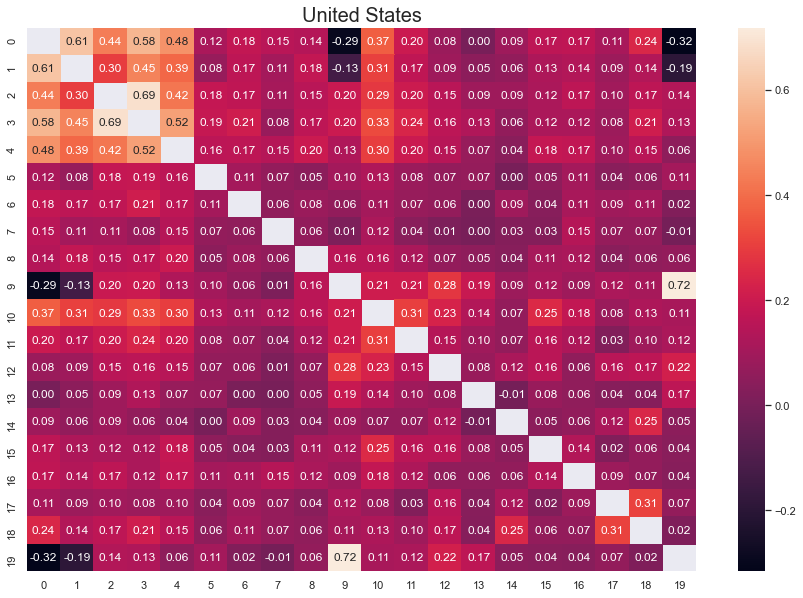

In [15]:
for loc, corr in zip(country_dict.keys(), corr_data):
    plt.figure(figsize=(15,10))
    sns.heatmap(corr, annot=True, fmt='0.2f')
    plt.title(loc)
    plt.show()
